In [4]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import multiprocessing

import pandas as pd
import datamol as dm
import numpy as np
import seaborn as sns

from molfeat.calc import RDKitDescriptors2D, FPCalculator, MordredDescriptors
from molfeat.trans import MoleculeTransformer
from sklearn.preprocessing import OneHotEncoder

import collections.abc as collections
from molfeat.trans.concat import FeatConcat

from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from src.config import mem
from src.utils import embed3d, eval_model, OffsetScaler
from src.descriptors import get_dgl_predictions, get_hft_predictions, get_3d_predictions

from rdkit import RDLogger, Chem

RDLogger.DisableLog('rdApp.*')

In [6]:
train = dm.read_csv("../data/processed/train.csv", smiles_column="smi", index_col=0)
test = dm.read_csv("../data/processed/test.csv", smiles_column="smi", index_col=0)
y_train = pd.read_pickle('../data/processed/y_train.pkl')

In [4]:
ohe = OneHotEncoder(sparse_output=False)

def get_x_train(feats):
    return np.concatenate([feats, ohe.fit_transform(train[["prop"]])], axis=1)

def get_x_test(feats):
    return np.concatenate([feats, ohe.transform(train[["test"]])], axis=1)

In [5]:
from molfeat.trans.fp import FPVecTransformer

from molfeat.trans.pretrained import PretrainedDGLTransformer
from molfeat.trans.pretrained.hf_transformers import PretrainedHFTransformer

dgl_params = [
    {'kind': 'gin_supervised_contextpred'},
    {'kind': 'gin_supervised_infomax'},
    {'kind': 'gin_supervised_edgepred'},
    {'kind': 'gin_supervised_masking'},
]

hft_params = [
    {'kind': 'MolT5', 'notation': 'smiles', 'random_seed': 42},
    {'kind': 'GPT2-Zinc480M-87M', 'notation': 'smiles', 'random_seed': 42},
    {'kind': 'Roberta-Zinc480M-102M', 'notation': 'smiles', 'random_seed': 42},    
]

params_3D = [
    {'kind': 'desc3D', 'length': 639, 'replace_nan': True},
    {'kind': 'cats3D', 'length': 126, 'replace_nan': True},
    {'kind': 'pharm3D', 'length': 1024, },
    {'kind': 'electroshape', 'length': 15, 'replace_nan': True},
    {'kind': 'usr', 'length': 12},
    {'kind': 'usrcat', 'length': 60},
]


transformers = [
    # fps
    FPVecTransformer("ecfp:4", length=1024, dtype=np.float32),
    FPVecTransformer("maccs", length=167, dtype=np.float32),
    FPVecTransformer("topological", length=1024, dtype=np.float32),
    FPVecTransformer("avalon", length=1024, dtype=np.float32),
    FPVecTransformer('erg', length=315, dtype=np.float32),    
    FPVecTransformer("layered", length=1024, dtype=np.float32),
    FPVecTransformer("secfp", length=1024, dtype=np.float32),
    FPVecTransformer('pattern', length=1024, dtype=np.float32),
    FPVecTransformer("pharm2D", n_jobs=-1, length=1024, dtype=np.float32),
    
    # normalize
    FPVecTransformer("estate", length=79, dtype=np.float32),
    FPVecTransformer("mordred", n_jobs=-1, length=1613, dtype=np.float32),
    FPVecTransformer("desc2D", n_jobs=-1, length=216, dtype=np.float32, replace_nan=True),
    FPVecTransformer("cats2D", n_jobs=-1, length=189, dtype=np.float32, replace_nan=True),
    FPVecTransformer("scaffoldkeys", n_jobs=-1, length=42, dtype=np.float32, replace_nan=True),
    FPVecTransformer("skeys", n_jobs=-1, length=42, dtype=np.float32, replace_nan=True),
]

# featurizer = FeatConcat(transformers, dtype=np.float32)

# calcucalte feats and cache them
for trans in transformers:
    print(trans.kind, '=' * 20)
    mem.cache(trans.transform)(train.smi)
    mem.cache(trans.transform)(test.smi)
        
for params in dgl_params:    
    mem.cache(get_dgl_predictions, ignore=['n_jobs', 'dtype'])(train.smi, params, dtype=np.float32)    
    mem.cache(get_dgl_predictions, ignore=['n_jobs', 'dtype'])(test.smi, params, dtype=np.float32)    

for params in desc3D_params:
    mem.cache(get_3d_predictions, ignore=['n_jobs', 'dtype'])(train.smi, params, dtype=np.float32)
    mem.cache(get_3d_predictions, ignore=['n_jobs', 'dtype'])(test.smi, params, dtype=np.float32)


# for params in hft_params:
#     feats = mem.cache(get_hft_predictions, ignore=['n_jobs', 'dtype', 'device'])(train.smi, params, device='cpu', n_jobs=-1)
    
# for kind, params in hft_params.items():
#     print('Initializing', end=' ')    
#     trans = PretrainedHFTransformer(kind, **params, n_jobs=-1)
#     print(kind, end=' ')
#     feats = mem.cache(trans.transform)(train.smi)
#     print(feats.shape[1])

ecfp:4 ====================
maccs ====================
topological ====================
avalon ====================
erg ====================
layered ====================
secfp ====================
pattern ====================
pharm2D ====================
estate ====================
mordred ====================
desc2D ====================
cats2D ====================
scaffoldkeys ====================
skeys ====================
________________________________________________________________________________
[Memory] Calling src.descriptors.get_3d_predictions...
get_3d_predictions(id
0                    Cc1cc(=O)oc2ccc3c(c12)C1(C)OOC1(C)O3
1                                          CN(CC(O)CO)N=O
2                            O=[N+]([O-])c1ccc(OC2CO2)cc1
3                            Cn1cnc2cc([N+](=O)[O-])ccc21
4                                      CCC(CO)NCCNC(CC)CO
                              ...                        
1216    CCN(CC)C(=O)COc1cc2c(O)c3c(O)c(C)c4c(c13)C(=O)...
1217   

[17:07:08] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[17:07:10] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[17:07:10] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[17:07:10] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[17:07:10] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[17:07:10] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[17:07:10] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[17:07:10] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[17:07:10] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[17:07:10] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[17:07:10] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[17:07:10] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[17:07:10] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[17:07:10] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[17:07:10] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[17:07:10]

KeyboardInterrupt: 

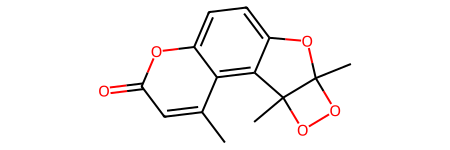

In [10]:
import datamol as dm
from src.utils import smi2mol

smi = '[H]c1c2c(c3c(C([H])([H])[H])c([H])c(=O)oc3c1[H])C1(C([H])([H])[H])OOC1(C([H])([H])[H])O2'
mol = smi2mol(smi)
mol

In [11]:
# dm.conformers.generate(mol, num_threads=12, n_confs=1, method='ETDG')
dm.conformers.generate(mol, num_threads=12, use_random_coords=True, energy_iterations=500)
# dm.conformers.generate(mol, random_seed=1)

ValueError: Conformers embedding failed for [H]c1c2c(c3c(C([H])([H])[H])c([H])c(=O)oc3c1[H])C1(C([H])([H])[H])OOC1(C([H])([H])[H])O2

In [10]:
embed3d(pd.Series(['[H]c1c2c(c3c(C([H])([H])[H])c([H])c(=O)oc3c1[H])C1(C([H])([H])[H])OOC1(C([H])([H])[H])O2']))

ValueError: Conformers embedding failed for [H]c1c2c(c3c(C([H])([H])[H])c([H])c(=O)oc3c1[H])C1(C([H])([H])[H])OOC1(C([H])([H])[H])O2

In [23]:
results = {}
clf = HistGradientBoostingClassifier(random_state=42)

for trans in transformers:
    feats = mem.cache(trans.transform)(train.smi)
    X_train = get_x_train(feats)            
    # print(f"{trans.kind} {trans.length} {feats.shape[1]}")    
    results[trans.kind] = eval_model(trans.kind, clf, X_train, y_train)    
    
for params in dgl_params:
    feats = mem.cache(get_dgl_predictions, ignore=['n_jobs', 'dtype'])(train.smi, params)    
    X_train = get_x_train(feats)    
    label = f"{params['kind']} {feats.shape[1]}"
    # print(label)
    results[params['kind']] = eval_model(label, clf, X_train, y_train)

ecfp:4          0.8717    (0.881 ± 0.009)    10.3s
maccs           0.8825    (0.891 ± 0.009)    2.8s
topological     0.8627    (0.870 ± 0.007)    9.7s
avalon          0.8866    (0.896 ± 0.009)    10.5s
erg             0.8627    (0.871 ± 0.008)    3.3s
layered         0.8857    (0.893 ± 0.007)    10.8s
secfp           0.8755    (0.883 ± 0.008)    10.5s
estate          0.8715    (0.876 ± 0.005)    2.2s
pattern         0.8796    (0.889 ± 0.009)    10.4s
mordred         0.8943    (0.899 ± 0.004)    28.2s
desc2D          0.8951    (0.901 ± 0.005)    3.7s
cats2D          0.8621    (0.870 ± 0.008)    2.8s
pharm2D         0.8296    (0.840 ± 0.011)    10.3s
scaffoldkeys    0.8542    (0.865 ± 0.010)    1.9s
skeys           0.8542    (0.865 ± 0.010)    2.1s
gin_supervised_contextpred 300 0.8699    (0.878 ± 0.008)    5.5s
gin_supervised_infomax 300 0.8639    (0.872 ± 0.008)    5.2s
gin_supervised_edgepred 300 0.8724    (0.880 ± 0.008)    5.0s
gin_supervised_masking 300 0.8665    (0.877 ± 0.010)   

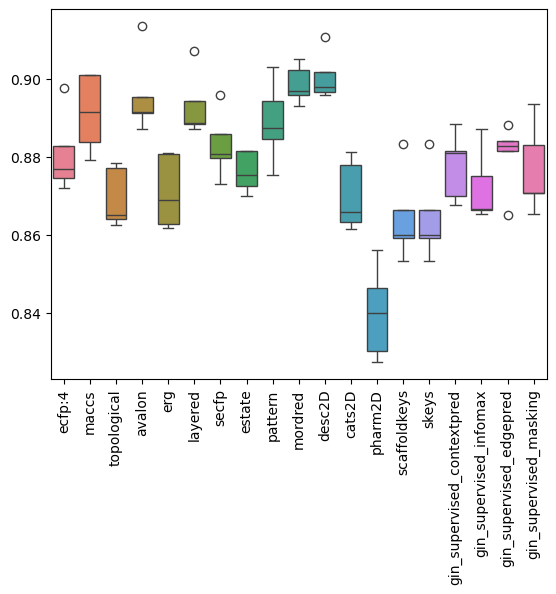

In [24]:
from matplotlib import pyplot as plt

sns.boxplot(pd.DataFrame(results))
plt.xticks(rotation=90);

In [6]:
train['mol3d'] = mem.cache(embed3d)(train.smi, n_confs=None)
test['mol3d'] = mem.cache(embed3d)(test.smi, n_confs=None)

In [16]:
for trans in transformers3d:
    feats = trans.transform(train.mol3d, ignore_errors=True)
    if isinstance(feats, list):
        # replace None with np.array of np.nan
        res = [a if a is not None else np.full(trans.length, np.nan) for a in feats]        
        imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        feats = imp.fit_transform(np.stack(res))
        
    print(trans.kind, trans.length, feats.shape[1])
    
    X_train = get_x_train(feats)
    results[trans.kind] = eval_model(trans.kind, clf, X_train, y_train)
    # train_ft = np.hstack([train_all_feats, feats])

desc3D 639 639
nans: 0
desc3D 639     : 0.8380    (0.846 ± 0.008)    8.5s
cats3D 126 126
nans: 0
cats3D 126     : 0.8502    (0.861 ± 0.011)    1.9s
pharm3D 1024 1024
nans: 0
pharm3D 1024   : 0.8315    (0.840 ± 0.008)    9.2s
electroshape 15 15
nans: 0
electroshape 15: 0.7851    (0.796 ± 0.011)    1.5s
usr 12 12
nans: 0
usr 12         : 0.7275    (0.737 ± 0.010)    1.4s
usrcat 60 60
nans: 0
usrcat 60      : 0.8118    (0.819 ± 0.007)    1.8s


In [ ]:
# groups = {
#     'kind': [ids]
# }

# Get indices for all feats

In [62]:
from src.utils import drop_nans_non_unique
from src.corr import non_corr_features

def filter_mordred(feats: np.ndarray):
    df = pd.DataFrame(feats)
    df_filtered = drop_nans_non_unique(df)
    df_filtered = non_corr_features(df_filtered, y_train, threshold=0.95)
    return df_filtered.values

# feats = mem.cache(FPVecTransformer("mordred", n_jobs=-1, length=1613, dtype=np.float32).transform)(train.smi)
# filter_mordred(feats).shape

(7939, 444)

In [68]:
feat_ids = {}
train_all_feats = np.empty((train.shape[0], 0))

for trans in transformers:
    feats = mem.cache(trans.transform)(train.smi)
    if trans.kind =='mordred':
        feats = filter_mordred(feats)
    curr_offset = train_all_feats.shape[1]
    feat_ids[trans.kind] = list(range(curr_offset, curr_offset + feats.shape[1]))    
    # print(trans.kind, feat_ids[trans.kind][0], feat_ids[trans.kind][-1])  # debug
    train_all_feats = np.hstack([train_all_feats, feats])

In [102]:
train_all_feats.shape

(7939, 11738)

In [70]:
for params in dgl_params:    
    feats = mem.cache(get_dgl_predictions, ignore=['n_jobs', 'dtype'])(train.smi, params)
    curr_offset = train_all_feats.shape[1]
    feat_ids[params['kind']] = list(range(curr_offset, curr_offset + feats.shape[1]))
    train_all_feats = np.hstack([train_all_feats, feats])

In [71]:
train_all_feats.shape

(7939, 9862)

In [72]:
for params in desc3D_params:
    feats = mem.cache(get_3d_predictions, ignore=['n_jobs', 'dtype'])(train.smi, params)
    feats = mem.cache(get_3d_predictions, ignore=['n_jobs', 'dtype'])(test.smi, params)
    if isinstance(feats, list):
        # replace None with np.array of np.nan
        res = [a if a is not None else np.full(feats.shape[1], np.nan) for a in feats]
        imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        feats = imp.fit_transform(np.stack(res))
    
    curr_offset = train_all_feats.shape[1]
    feat_ids[trans.kind] = list(range(curr_offset, curr_offset + feats.shape[1]))
    train_all_feats = np.hstack([train_all_feats, feats])

train_all_feats.shape

(7939, 11738)

In [84]:
fps_names = [
    "ecfp:4",
    "maccs",
    "topological",
    "avalon",
    "erg",
    "layered",
    "secfp",
    "pattern",
    "pharm2D"
]


In [103]:
fps_offset = sum([len(feat_ids[k]) for k in fps_names])
fps_offset

7650

In [105]:
scaler = OffsetScaler(fps_offset)
train_scaled = scaler.fit_transform(train_all_feats)

In [108]:
train_scaled.shape

(7939, 11738)

In [110]:
X_train = get_x_train(train_scaled)

In [111]:
X_train.shape

(7939, 11741)

In [ ]:
pd.DataFrame(X_train).to_pickle('../data/processed/X_train_all.pkl.zip')

In [114]:
import pickle

with open('../data/processed/feat_ids_all.pkl', 'wb') as f:
    pickle.dump(feat_ids, f)

In [14]:
from src.utils import drop_nans_non_unique
from src.corr import non_corr_features

def filter_mordred(feats: np.ndarray):
    df = pd.DataFrame(feats)
    df_filtered = drop_nans_non_unique(df)
    df_filtered = non_corr_features(df_filtered, y_train, threshold=0.95)
    return df_filtered.values

def generate_feats(df):
    all_feats = np.empty((df.shape[0], 0))

    def append_feat(name, feats):
        curr_offset = all_feats.shape[1]
        feat_ids[name] = list(range(curr_offset, curr_offset + feats.shape[1]))
        all_feats = np.hstack([all_feats, feats])


    for trans in transformers:
        feats = mem.cache(trans.transform)(df.smi)
        if trans.kind =='mordred':
            feats = filter_mordred(feats)

        append_feat(trans.kind, feats)

    for params in dgl_params:
        feats = mem.cache(get_dgl_predictions, ignore=['n_jobs', 'dtype'])(df.smi, params)

        append_feat(params['kind'], feats)

    for params in desc3D_params:
        feats = mem.cache(get_3d_predictions, ignore=['n_jobs', 'dtype'])(df.smi, params)
        if isinstance(feats, list):
            # replace None with np.array of np.nan
            res = [a if a is not None else np.full(feats.shape[1], np.nan) for a in feats]
            imp = SimpleImputer(missing_values=np.nan, strategy='mean')
            feats = imp.fit_transform(np.stack(res))

        append_feat(params['kind'], feats)

    return all_feats

In [ ]:
train_all_feats = generate_feats(train)

In [31]:

X_train = np.concatenate([train_all_feats, ohe.fit_transform(train[["prop"]])], axis=1)
X_train.shape

(7939, 9110)

In [32]:
eval_model('all stack', clf, X_train, y_train);

all stack: 0.8974    (0.905 ± 0.007)    204.7s


In [39]:
from src.config import mem
mord = FPVecTransformer("mordred", n_jobs=-1, dtype=np.float32)

md_feats = mem.cache(mord.transform)(train.smi)

In [60]:
from src.utils import drop_nans_non_unique
df = pd.DataFrame(md_feats)
na_cols = df.isna().sum() > 1
const_cols = df.nunique() == 1
md_mask = ~(na_cols | const_cols)

In [68]:
from src.corr import non_corr_features

uncorr = non_corr_features(df.loc[:, md_mask], y_train, threshold=0.95)
md_mask.sum(), uncorr.shape[1]

(1009, 497)

In [59]:
md_feats[:, md_mask].shape

(7939, 1009)

502

In [18]:
X_test = np.concatenate([test_ft, ohe.transform(test[["property"]].to_numpy())], axis=-1)

In [19]:
preds = clf.predict_proba(X_test)